# TP3 : Introduction au boostrap et aux méthodes gloutonnes

## Setup

In [1]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model.base import LinearModel
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn import datasets, linear_model
from sklearn.base import RegressorMixin

from scipy.stats import gaussian_kde, norm
from scipy.optimize import minimize, minimize_scalar

import statsmodels.datasets as sd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
matplotlib.rcParams['figure.figsize']=(14,8) # Defini la taille des figures
plt.style.use('ggplot') # Style predefini pour l'affichage des figures

## Exercice 1 : Régression robuste

### Question 1

1) Générer n = 100 vecteurs aléatoires (yi, xi) selon le modèle précédent avec d = 2, θ = (1,1), θ0 = 1 et εi gaussien de moyenne 0 et variance 1. La simulation du jeu de données nous permet de maitriser certaines données du modèle telle que la loi des résidus. Jusqu'à la question 7), on travail uniquement sur les (yi, xi) générés ici.

In [2]:
# Constante
d = 2
teta0 = 1
teta = np.array([1,1]).reshape(-1,1)

#NEW
X = np.random.uniform(0, 1, (100, d))
error = np.random.standard_normal(100).reshape(-1,1)
Y = teta0 + np.dot(X, teta) + error

print("X.shape : ", X.shape)
print("Y.shape : ", Y.shape)

X.shape :  (100, 2)
Y.shape :  (100, 1)


### Question 2

2) Sur un même graphique, dont l'abscisse minimal et maximal seraient -5 et 5, tracer pα pour α = .5, 2, 5. Décrire (par rapport aux résidus du modèle) l'effet de α sur l'estimation de θˆα.

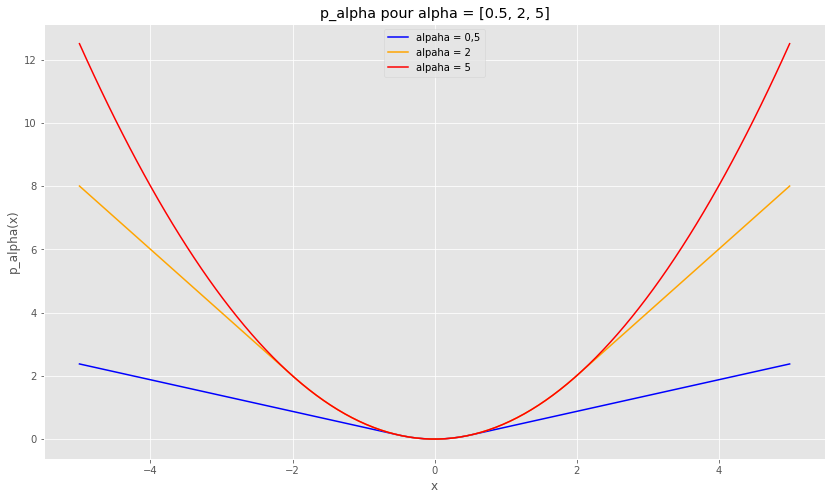

In [3]:
# Compute p_alpha
def compute_p_alpha(alpha, X):
    if alpha == 0:
        return np.abs(X)
    else:
        boolean = np.less_equal(np.abs(X), alpha)
        Y = alpha*np.abs(X)-alpha**2/2
        Y[boolean] = (X[boolean])**2/2
        return Y

# Calcul de l'axe des abcisses du graphe
ax = np.linspace(-5, 5, 100)

# Affichage du graphe
plt.plot(ax,compute_p_alpha(0.5, ax), label="alpaha = 0,5", color="blue")
plt.plot(ax,compute_p_alpha(2, ax), label="alpaha = 2", color="orange")
plt.plot(ax,compute_p_alpha(5, ax), label="alpaha = 5", color="red")
plt.title("p_alpha pour alpha = [0.5, 2, 5]")
plt.xlabel("x"), plt.ylabel("p_alpha(x)")
plt.legend(loc=9)
plt.show()

> Le graphique ci-dessus nous montre l'influence de $\alpha$, su la fonction $\rho_{\alpha}(x)$. 

> On remarque que plus $\alpha$ est grand, plus il se rapproche d'une méthode des moindres carrés.

### Question 3

3) Pour α = 2, calculer θˆα.

In [4]:
# Theta init
init = [[0, 0, 0]]

def compute_minimize(X, Y, alpha=2, theta_init=init):

    def f(theta):
        t0 = theta[0].reshape(-1,1)
        t = theta[1:].reshape(-1,1)
        X_p = Y - t0 - np.dot(X, t)
        teta_alpha = np.sum(compute_p_alpha(alpha, X_p))
        # print("params" + str(params) + " => teta_alpha : " + str(teta_alpha))
        return teta_alpha

    result = minimize(f, theta_init, method='nelder-mead',options={'xtol': 1e-5})
    return result

In [5]:
result = compute_minimize(X, Y, alpha=2)
if result.success:
    teta_hat = result.x
    print("teta_hat : " + str(teta_hat))
    teta0_hat = teta_hat[0]
    teta1_hat = teta_hat[1:]
else:
    raise ValueError(result.message)

teta_hat : [ 0.28430461  2.18915171  1.2335978 ]


### Question 4

4) En utilisant le bootstrap des résidus, calculer un estimateur bootstrap θˆ*α pour α = 2.

In [6]:
# Calcul de g_hat
g_hat = np.dot(X, teta1_hat).reshape(-1,1)

# Residus estimes
residus = Y - g_hat

# Tirer uniformément avec remise dans residus[0], ..., residus[n]
tirage_uniform = np.random.randint(0, len(residus)-1, (len(residus),1))
residu_bootstrap = residus[tirage_uniform].reshape(len(residus), 1)

# Pour i = 1, ..., n, calculer Yi* = gˆ(Xi) + residu_bootstrap
Y_etoile = g_hat + residu_bootstrap
    
# A partir de (Y1*, X1, ..., Yn*, Xn), réestimer teta*
result = compute_minimize(X, Y_etoile, alpha=2)
if result.success:
    teta_hat_etoile = result.x
    print("teta_hat_etoile : " + str(teta_hat_etoile))
    teta0_hat_etoile = teta_hat_etoile[0]
    teta1_hat_etoile = teta_hat_etoile[1:]
else:
    raise ValueError(result.message)


teta_hat_etoile : [ 0.16602824  2.65777589  1.18691021]


### Question 5

5) Toujours pour α = 2, à partir de B = 200 réplications d'estimateurs bootstrap θˆ\*1,α, . . . , θˆ\*B,α (issues de la question précédente), calculer un estimateur de la matrice de variance Vboot et un estimateur du biais bboot de l'estimateur θˆα. On calculera aussi l'estimateur de l'erreur quadratique moyenne associée à l'estimateur, donner par...

In [7]:
B=200 # nombre de réplications

def compute_teta_hat_etoile(X, Y, teta_hat, alpha=2, B=200, theta_init=init):
    theta_200_rep = []
    for i in range(B):
        # Calcul de g_hat
        t0 = teta_hat[0].reshape(-1,1)
        t = teta_hat[1:].reshape(-1,1)
        g_hat = np.dot(X, t).reshape(-1,1)

        # Residus estimes
        residus = Y - g_hat

        # Tirer uniformément avec remise dans residus[0], ..., residus[n]
        tirage_uniform = np.random.randint(0, len(residus)-1, (len(residus),1))
        residu_bootstrap = residus[tirage_uniform].reshape(len(residus), 1)

        # Pour i = 1, ..., n, calculer Yi* = gˆ(Xi) + residu_bootstrap
        Y_etoile = g_hat + residu_bootstrap

        # A partir de (Y1*, X1, ..., Yn*, Xn), réestimer teta*
        result = compute_minimize(X, Y_etoile, alpha=alpha, theta_init=theta_init)
        current_teta_hat_etoile = result.x
        theta_200_rep.append(current_teta_hat_etoile)

    theta_200_rep = np.asarray(theta_200_rep)
    return theta_200_rep

In [8]:
theta_200_rep = compute_teta_hat_etoile(X, Y, teta_hat, alpha=2, B=200)

# Calcul estimateur de la matrice de variance Vboot
Vboot = np.cov(theta_200_rep, rowvar=False)
print("L'estimateur de la variance Vboot est égale à : \n", Vboot)

# Calcul estimateur du biais bboot de l'estimateur teta_alpha_hat
Bboot = (1/B) * np.sum(theta_200_rep - teta_hat)
print("\nL'estimateur du biais bboot est égale à : \n", Bboot)

# Calcul de  l'estimateur de l'erreur quadratique moyenne associée à l'estimateur
EQMboot = (1/B) * np.sum(np.linalg.norm(theta_200_rep - teta_hat)**2)
print("\nL'estimateur de l'erreur quadratique, EQMboot, est égale à : \n", EQMboot)


L'estimateur de la variance Vboot est égale à : 
 [[ 0.07443641 -0.07451167 -0.05538264]
 [-0.07451167  0.14219099  0.00868344]
 [-0.05538264  0.00868344  0.0984648 ]]

L'estimateur du biais bboot est égale à : 
 0.0344937532154

L'estimateur de l'erreur quadratique, EQMboot, est égale à : 
 0.314446204313


### Question 6

6) En remarquant que EQMboot(α) est un estimateur du risque, proposez une procédure permettant de choisir le meilleur α consiste à sélectionner le α qui minimise EQMboot(α). Sur une grille de 20 points équidistants entre 0 et 10, tracer EQMboot(α) pour α variant sur cette grille.

In [9]:
# Grille de 20 points équidistants entre 0 et 10
alpha_grid = np.linspace(0,10,20)

def minimize_EQMboot(X, Y, alpha_grid=alpha_grid, B=200, theta_init=init):
    # Liste des erreurs quadratiques en fonction de alpha
    EQMboot_alpha = []

    for alpha in alpha_grid:
        # Calcul tmp_teta_hat
        tmp_teta_hat = compute_minimize(X, Y, alpha=alpha, theta_init=theta_init).x

        # Calcul tmp_teta_hat_etoile_200_rep
        tmp_teta_hat_etoile_200_rep = compute_teta_hat_etoile(X, Y, tmp_teta_hat, alpha=alpha, B=200, theta_init=theta_init)

        # Calcul tmp_EQMboot
        tmp_EQMboot = (1/B) * np.sum(np.linalg.norm(tmp_teta_hat_etoile_200_rep - tmp_teta_hat)**2)
        print("alpha : " + str(alpha) + " => tmp_EQMboot : " + str(tmp_EQMboot))    
        EQMboot_alpha.append(tmp_EQMboot)
        
    return EQMboot_alpha

In [10]:
# Calcul des erreurs quadratiques en fonction de alpha
EQMboot_alpha = minimize_EQMboot(X, Y, alpha_grid=alpha_grid, B=200)

alpha : 0.0 => tmp_EQMboot : 1.16535103623
alpha : 0.526315789474 => tmp_EQMboot : 0.375647597082
alpha : 1.05263157895 => tmp_EQMboot : 0.324584666903
alpha : 1.57894736842 => tmp_EQMboot : 0.330016379853
alpha : 2.10526315789 => tmp_EQMboot : 0.324266155326
alpha : 2.63157894737 => tmp_EQMboot : 0.292747782697
alpha : 3.15789473684 => tmp_EQMboot : 0.30451006025
alpha : 3.68421052632 => tmp_EQMboot : 0.336995767081
alpha : 4.21052631579 => tmp_EQMboot : 0.311412456368
alpha : 4.73684210526 => tmp_EQMboot : 0.283506989681
alpha : 5.26315789474 => tmp_EQMboot : 0.342249269405
alpha : 5.78947368421 => tmp_EQMboot : 0.268205163538
alpha : 6.31578947368 => tmp_EQMboot : 0.330207496574
alpha : 6.84210526316 => tmp_EQMboot : 0.295993520773
alpha : 7.36842105263 => tmp_EQMboot : 0.280296279744
alpha : 7.89473684211 => tmp_EQMboot : 0.330887292456
alpha : 8.42105263158 => tmp_EQMboot : 0.290443143013
alpha : 8.94736842105 => tmp_EQMboot : 0.27568413098
alpha : 9.47368421053 => tmp_EQMboot : 0

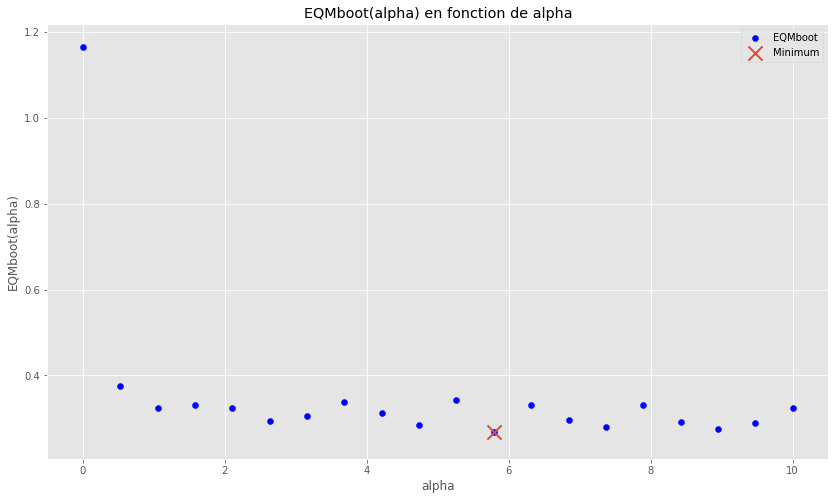

In [11]:
# Affichage des erreurs quadratiques en fonction de alpha
fig, ax = plt.subplots()
ax.scatter(alpha_grid, EQMboot_alpha, c='blue', label="EQMboot")
min_EQMboot_index = np.argmin(EQMboot_alpha)
ax.scatter(alpha_grid[min_EQMboot_index], EQMboot_alpha[min_EQMboot_index],
           marker="x", s=200, linewidth=2, label="Minimum")

# Parametres affichage
plt.title("EQMboot(alpha) en fonction de alpha")
plt.xlabel("alpha") ; plt.ylabel("EQMboot(alpha)")
plt.legend(loc=1)
plt.show()

In [12]:
print("\nL'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à : ", alpha_grid[np.argmin(EQMboot_alpha)])
print("\nAvec cette valeur de alpha, EQMboot est égal à : ", np.min(EQMboot_alpha))


L'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à :  5.78947368421

Avec cette valeur de alpha, EQMboot est égal à :  0.268205163538


### Question 7

7) On change maintenant la distribution des erreurs. On prend une loi standard de Cauchy (générée sous numpy par numpy.random.standard_cauchy(n)). Tracer le même graphique qu'à la question précédente. Conclure

In [13]:
error_cauchy = np.random.standard_cauchy(100).reshape(-1,1)

Y_cauchy = teta0 + np.dot(X, teta) + error_cauchy

# Calcul des erreurs quadratiques en fonction de alpha
EQMboot_alpha_cauchy = minimize_EQMboot(X, Y_cauchy, alpha_grid=alpha_grid, B=200)


alpha : 0.0 => tmp_EQMboot : 0.70435840829
alpha : 0.526315789474 => tmp_EQMboot : 0.838923982942
alpha : 1.05263157895 => tmp_EQMboot : 1.06128311039
alpha : 1.57894736842 => tmp_EQMboot : 0.87948147217
alpha : 2.10526315789 => tmp_EQMboot : 1.24989479192
alpha : 2.63157894737 => tmp_EQMboot : 1.30993566766
alpha : 3.15789473684 => tmp_EQMboot : 1.35499123485
alpha : 3.68421052632 => tmp_EQMboot : 1.79572990263
alpha : 4.21052631579 => tmp_EQMboot : 1.83838843122
alpha : 4.73684210526 => tmp_EQMboot : 2.08819302007
alpha : 5.26315789474 => tmp_EQMboot : 2.32755212467
alpha : 5.78947368421 => tmp_EQMboot : 2.43908262607
alpha : 6.31578947368 => tmp_EQMboot : 3.00686033339
alpha : 6.84210526316 => tmp_EQMboot : 2.877844329
alpha : 7.36842105263 => tmp_EQMboot : 3.47236496129
alpha : 7.89473684211 => tmp_EQMboot : 3.70278544969
alpha : 8.42105263158 => tmp_EQMboot : 4.12317454384
alpha : 8.94736842105 => tmp_EQMboot : 4.31723492868
alpha : 9.47368421053 => tmp_EQMboot : 4.38738947575
alp

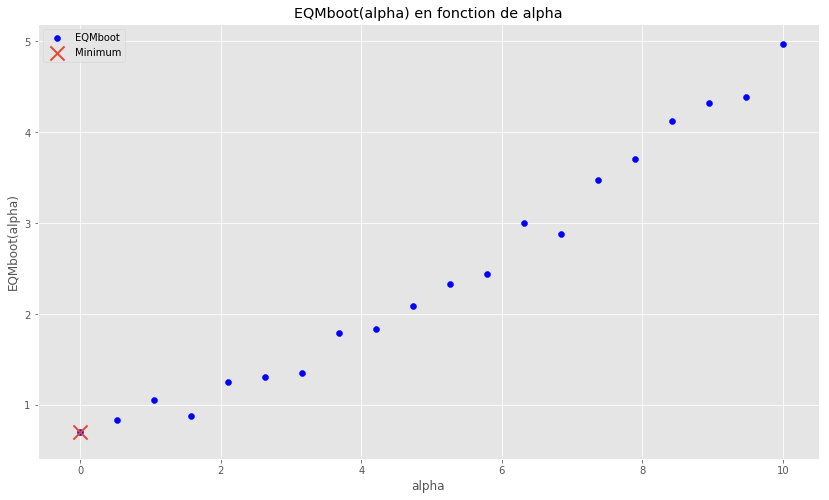

In [14]:
# Affichage des erreurs quadratiques en fonction de alpha
fig, ax = plt.subplots()
ax.scatter(alpha_grid, EQMboot_alpha_cauchy, c='blue', label="EQMboot")
min_EQMboot_cauchy_index = np.argmin(EQMboot_alpha_cauchy)
ax.scatter(alpha_grid[min_EQMboot_cauchy_index], EQMboot_alpha_cauchy[min_EQMboot_cauchy_index],
           marker="x", s=200, linewidth=2, label="Minimum")

# Parametres affichage
plt.title("EQMboot(alpha) en fonction de alpha")
plt.xlabel("alpha") ; plt.ylabel("EQMboot(alpha)")
plt.legend(loc=2)
plt.show()

In [15]:
print("\nL'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à : ", alpha_grid[np.argmin(EQMboot_alpha_cauchy)])
print("\nAvec cette valeur de alpha, EQMboot est égal à : ", np.min(EQMboot_alpha_cauchy))


L'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à :  0.0

Avec cette valeur de alpha, EQMboot est égal à :  0.70435840829


### Question 8

8) Charger la base "diabetese" de sklearn. Appliquer la méthode précédente au choix du coefficient α pour la régression de y sur la quatrième variable de la base. On veillera à bien choisir le domaine des α pour optimiser le EQMboot(α).

In [16]:
# Load data
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
Y_diabetes = diabetes.target

# Selection de la quatrieme variable de la base
feature_diabetes = X_diabetes[:, 3]
feature_diabetes = feature_diabetes.reshape(len(feature_diabetes), 1)

# Reshape Y_diabetes
Y_diabetes = Y_diabetes.reshape(len(Y_diabetes), 1)

# Definition du theta initial
theta_diabetes_init = np.zeros((2, 1)).reshape(-1,1)

In [17]:
# Calcul des erreurs quadratiques en fonction de alpha
alpha_grid_diabetes = np.linspace(0, 2000, 200)

EQMboot_alpha_diabetes = minimize_EQMboot(feature_diabetes, Y_diabetes, alpha_grid=alpha_grid_diabetes, B=200, theta_init=theta_diabetes_init)


alpha : 0.0 => tmp_EQMboot : 8673.14410862
alpha : 10.0502512563 => tmp_EQMboot : 9098.80414479
alpha : 20.1005025126 => tmp_EQMboot : 6580.10846647
alpha : 30.1507537688 => tmp_EQMboot : 7359.591892
alpha : 40.2010050251 => tmp_EQMboot : 8164.45459456
alpha : 50.2512562814 => tmp_EQMboot : 6651.09663835
alpha : 60.3015075377 => tmp_EQMboot : 5954.22674882
alpha : 70.351758794 => tmp_EQMboot : 5331.83203787
alpha : 80.4020100503 => tmp_EQMboot : 4755.36587773
alpha : 90.4522613065 => tmp_EQMboot : 5065.02994773
alpha : 100.502512563 => tmp_EQMboot : 5359.86143576
alpha : 110.552763819 => tmp_EQMboot : 4984.54032782
alpha : 120.603015075 => tmp_EQMboot : 4042.50609635
alpha : 130.653266332 => tmp_EQMboot : 4856.38174064
alpha : 140.703517588 => tmp_EQMboot : 4871.86071037
alpha : 150.753768844 => tmp_EQMboot : 4960.90852457
alpha : 160.804020101 => tmp_EQMboot : 4847.38662283
alpha : 170.854271357 => tmp_EQMboot : 4833.38323184
alpha : 180.904522613 => tmp_EQMboot : 4795.89018676
alpha 

alpha : 1567.83919598 => tmp_EQMboot : 4106.26033854
alpha : 1577.88944724 => tmp_EQMboot : 4425.7822604
alpha : 1587.93969849 => tmp_EQMboot : 5227.64960272
alpha : 1597.98994975 => tmp_EQMboot : 4571.31180625
alpha : 1608.04020101 => tmp_EQMboot : 4971.03712573
alpha : 1618.09045226 => tmp_EQMboot : 4233.35870558
alpha : 1628.14070352 => tmp_EQMboot : 4746.20878127
alpha : 1638.19095477 => tmp_EQMboot : 4808.58092608
alpha : 1648.24120603 => tmp_EQMboot : 4183.59463573
alpha : 1658.29145729 => tmp_EQMboot : 4691.61180866
alpha : 1668.34170854 => tmp_EQMboot : 5190.2067647
alpha : 1678.3919598 => tmp_EQMboot : 4519.96749914
alpha : 1688.44221106 => tmp_EQMboot : 5541.41993751
alpha : 1698.49246231 => tmp_EQMboot : 4127.44349594
alpha : 1708.54271357 => tmp_EQMboot : 5224.84749668
alpha : 1718.59296482 => tmp_EQMboot : 4661.58480901
alpha : 1728.64321608 => tmp_EQMboot : 4843.86447221
alpha : 1738.69346734 => tmp_EQMboot : 4679.58396669
alpha : 1748.74371859 => tmp_EQMboot : 4901.32903

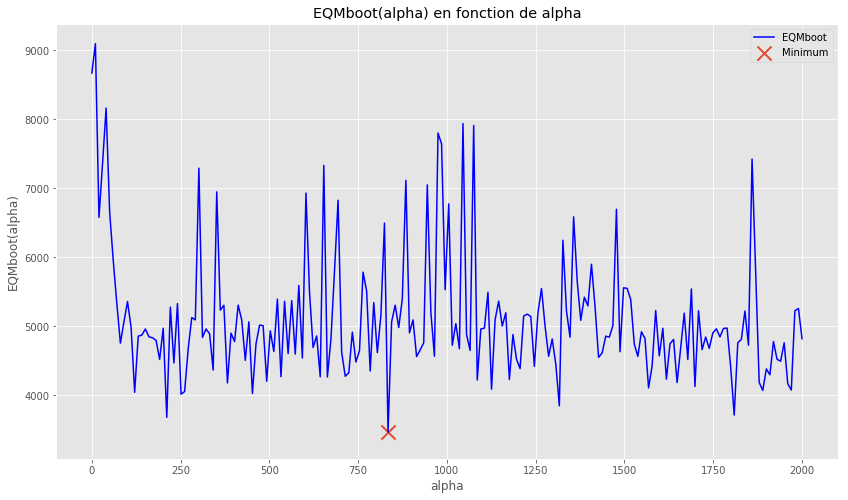

In [18]:
# Affichage des erreurs quadratiques en fonction de alpha
fig, ax = plt.subplots()
ax.plot(alpha_grid_diabetes, EQMboot_alpha_diabetes, c='blue', label="EQMboot")
min_EQMboot_diabetes_index = np.argmin(EQMboot_alpha_diabetes)
ax.scatter(alpha_grid_diabetes[min_EQMboot_diabetes_index], EQMboot_alpha_diabetes[min_EQMboot_diabetes_index],
           marker="x", s=200, linewidth=2, label="Minimum")

# Parametres affichage
plt.title("EQMboot(alpha) en fonction de alpha")
plt.xlabel("alpha") ; plt.ylabel("EQMboot(alpha)")
plt.legend(loc=1)
plt.show()

In [19]:
print("\nL'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à : ", alpha_grid_diabetes[np.argmin(EQMboot_alpha_diabetes)])
print("\nAvec cette valeur de alpha, EQMboot est égal à : ", np.min(EQMboot_alpha_diabetes))


L'estimateur de l'erreur quadratique, EQMboot, est minimal pour alpha égale à :  834.170854271

Avec cette valeur de alpha, EQMboot est égal à :  3465.47616486


## Exercice 2 : Algorithmes gloutons ou greedy

On se place dans le cadre du modèle linéaire et l'on considère la base de données airquality. Attention, on veillera à éliminer les possibles valeurs manquantes. On prend comme variable à prédire la concentration d'Ozone, les autres variables seront les variables explicatives du modèle.

In [20]:
# Load data
data = sd.get_rdataset('airquality').data

# Supprime toutes les lignes ayant des valeurs manquantes
airquality = data.dropna(axis=0, how='any')

# Affiche le nouveau nombre de ligne supprimé apres "nettoyage"
print("Nombre de lignes supprimés : " + str(len(data) - len(airquality)))

Nombre de lignes supprimés : 42


In [21]:
airquality.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
6,23.0,299.0,8.6,65,5,7


### Question 9

9) ) Standardiser les données (centrer et réduire pour obtenir une matrice X qui a des variances unitaire par colonne).

In [22]:
# Variable à prédire
y_air = airquality['Ozone'].as_matrix().reshape(-1,1)
print("Type y_air : ", type(y_air))
print("Shape y_air : ", y_air.shape)

# Variables explicatives
variables_explicatives = ['Solar.R','Wind','Temp','Month','Day']
X_air = airquality[variables_explicatives].as_matrix()
print("\nType X_air : ", type(X_air))
print("Shape X_air : ", X_air.shape)

# Standardisation des variables explicatives
X_std_air = StandardScaler().fit(X_air).transform(X_air)
print("\nType X_std_air : ", type(X_std_air))
print("Shape X_std_air : ", X_std_air.shape)

Type y_air :  <class 'numpy.ndarray'>
Shape y_air :  (111, 1)

Type X_air :  <class 'numpy.ndarray'>
Shape X_air :  (111, 5)

Type X_std_air :  <class 'numpy.ndarray'>
Shape X_std_air :  (111, 5)


### Question 10

10)  Écrivez une fonction stpforward qui prend comme argument : les observations y, la matriceX, et enfin un paramètre M qui est le nombre de variables sélectionnées (les entrees seront des numpy arrays). En sortie, la fonction doit renvoyer la listes selected_variables contenant les indices des variables sélectionnées et le vecteur θ appartient à Rp (dont les coordonnées sont nulles sauf les θj pour les indices j dans selected_variables) correspondant à l'estimation des moindres carrés effectuée seulement sur les variables dont les indices sont dans selected_variables.

In [23]:
def stpforward(X, y, M):
    """Orthogonal Matching Pursuit model (OMP).
    X: Array-like, shape (n_samples, n_features).
    Training data.
    y: Array-like, shape (n_samples, ).
    Target values.
    M: Integer, in [1,n_features]
    """
    selected_variables = []
    residual = y
    p = X.shape[1]
    coef_selected = np.zeros(p)
    for i in range(1, M + 1):
        tab_alphaj = np.zeros(p)
        for j in range(0, p):
            if(j not in selected_variables):
                # Compute Alphaj and add it in tab_Alphaj
                Xj = X[:, j]
                # XXX: Get alpha_j value here
                valeur_alphaj = np.abs(Xj.dot(residual))
                tab_alphaj[j] = valeur_alphaj
        jmax = np.argmax(tab_alphaj)
        selected_variables.append(jmax)
        X_selected = X[:, selected_variables]
        # XXX: perform OLS over selected variables
        skl_linmod = linear_model.LinearRegression().fit(X_selected, y)
        y_pred = skl_linmod.predict(X_selected)
        # Store coefficients
        coef_selected[selected_variables] = skl_linmod.coef_
        # XXX: Update residual
        residual = y - y_pred
    return coef_selected, selected_variables

### Question 11

11) Créer une classe MYOMP qui implémente stpforward, en partant de l'exemple.

In [24]:
class MYOMP(LinearModel, RegressorMixin):
    """Orthogonal Matching Pursuit model (OMP).
    Parameters
    ----------
    n_nonzero_coefs : int, optional
    Desired number of non-zero entries in the solution. If None (by
    default) this value is set to 10% of n_features.
    """
    
    
    def __init__(self, n_nonzero_coefs=None, fit_intercept=False,
                normalize=False, precompute='auto'):
        self.fit_intercept = False
        self.normalize = normalize
        self.precompute = precompute
        self.n_nonzero_coefs = n_nonzero_coefs
    
    
    def fit(self, X, y):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Training data.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
        Target values.
        Returns
        -------
        self : object
        returns an instance of self.
        """
        self.coef_ = np.zeros([X.shape[1], ])
        # XXX: MODIFY HERE !!!
        coef_selected, selected_variables = stpforward(X, y, self.n_nonzero_coefs)
        self.coef_ = coef_selected
        self.selected_variables_ = selected_variables
        # END MODIFY
        self.intercept_ = 0.
        return self

### Question 12

12) Appliquer MYOMP au jeu de données, pour M = 1, 2, 3, 4, 5.

In [25]:
# Definition des différentes valeurs M
M = [1, 2, 3, 4, 5]

# Selection des coefficients avec la méthode MYOMP
for m in M:
    print('\nM : ', m)
    myomp = MYOMP(n_nonzero_coefs = m).fit(X_std_air, y_air)
    print('Coefficients sélectionnés: ', myomp.coef_)
    print('Variables sélectionnées : ', [variables_explicatives[i] for i in myomp.selected_variables_])


M :  1
Coefficients sélectionnés:  [  0.           0.          23.13969957   0.           0.        ]
Variables sélectionnées :  ['Temp']

M :  2
Coefficients sélectionnés:  [  0.         -11.66917173  17.33790739   0.           0.        ]
Variables sélectionnées :  ['Temp', 'Wind']

M :  3
Coefficients sélectionnés:  [  5.42816683 -11.80641781  15.67331326   0.           0.        ]
Variables sélectionnées :  ['Temp', 'Wind', 'Solar.R']

M :  4
Coefficients sélectionnés:  [  4.50045463 -11.74591966  17.7488752   -4.38806519   0.        ]
Variables sélectionnées :  ['Temp', 'Wind', 'Solar.R', 'Month']

M :  5
Coefficients sélectionnés:  [  4.56193076 -11.75277084  17.98521995  -4.45895297   2.37393859]
Variables sélectionnées :  ['Temp', 'Wind', 'Solar.R', 'Month', 'Day']


### Question 13

13) Comparer votre sortie avec celle de OrthogonalMatchingPursuit de sklearn.

In [26]:
# Comparaison de la selection des coefficients avec les méthode MYOMP et OrthogonalMatchingPursuit
for m in M:
    print('\n=========================================== M : ', m, "=========================================== ")
    print('-----> MYOMP :')
    # Selection des coefficients avec la méthode MYOMP
    myomp = MYOMP(n_nonzero_coefs = m).fit(X_std_air, y_air)
    print('Coefficients sélectionnés: ', myomp.coef_)
    print('Variables sélectionnées : ', [variables_explicatives[i] for i in myomp.selected_variables_])
    
    print('\n-----> OrthogonalMatchingPursuit (sklearn) :')
    # Selection des coefficients avec la méthode OrthogonalMatchingPursuit
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=m).fit(X_std_air, y_air)
    coef = omp.coef_
    idx_r, = coef.nonzero()
    print('Coefficients sélectionnés: ', coef)
    print('Variables sélectionnées : ', [variables_explicatives[i] for i in idx_r])
    
    # Verification de l'égalité entre les résultats
    print("\nEgalité entre les résultats : ", np.isclose(myomp.coef_, coef))



=========================================== M :  1 =========================================== 
-----> MYOMP :
Coefficients sélectionnés:  [  0.           0.          23.13969957   0.           0.        ]
Variables sélectionnées :  ['Temp']

-----> OrthogonalMatchingPursuit (sklearn) :
Coefficients sélectionnés:  [  0.           0.          23.13969957   0.           0.        ]
Variables sélectionnées :  ['Temp']

Egalité entre les résultats :  [ True  True  True  True  True]

=========================================== M :  2 =========================================== 
-----> MYOMP :
Coefficients sélectionnés:  [  0.         -11.66917173  17.33790739   0.           0.        ]
Variables sélectionnées :  ['Temp', 'Wind']

-----> OrthogonalMatchingPursuit (sklearn) :
Coefficients sélectionnés:  [  0.         -11.66917173  17.33790739   0.           0.        ]
Variables sélectionnées :  ['Wind', 'Temp']

Egalité entre les résultats :  [ True  True  True  True  True]

===============

> Les deux méthodes sélectionnent les mêmes paramètres.

### Question 14

14) Utiliser une validation croisée (avec 3 folds) pour choisir le nombre de variables à garder, en prenant comme critère de performance l'erreur quadratique (moyennée sur les folds). Faut-il en garder 1, 2, 3, 4 ou bien 5 variables sur cet exemple ? On veillera à utiliser la fonction GridSearchCV.

In [27]:
cv_fold = 3
tuned_parameters = [{'n_nonzero_coefs': np.arange(1,6,1)}]
cv = GridSearchCV(OrthogonalMatchingPursuit(), tuned_parameters,cv=3, refit=False).fit(X_std_air, y_air)

print("\nBest params : ", cv.best_params_)

print("\nSelon la validation croisée, il faut donc garder : ", cv.best_params_['n_nonzero_coefs'], "variables.")


Best params :  {'n_nonzero_coefs': 5}

Selon la validation croisée, il faut donc garder :  5 variables.


### Question 15

15) Afficher sur un graphique l'erreur quadratique (moyennée sur les folds) en fonction de M. Ajoutez-y la valeur de l'optimal sélectionnée ainsi qu'un un intervalle de confiance à + ou - un écart-type de cette erreur.

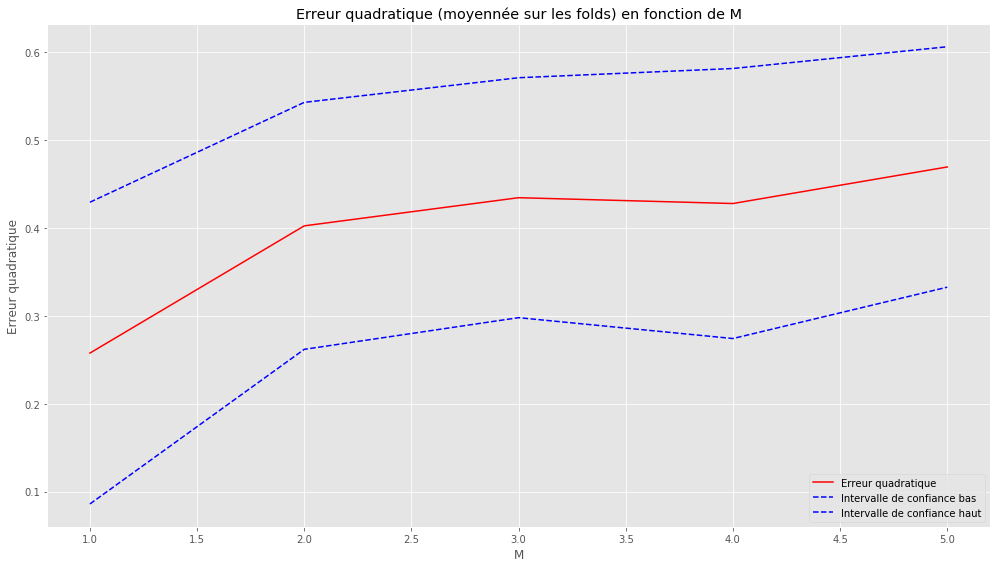

In [28]:
# Calcul et affichage de l'erreur quadratique
erreur_quadratique = cv.cv_results_['mean_test_score']
plt.plot(M, erreur_quadratique, label='Erreur quadratique', color='red')

# Calcul de l'ecart type de l'erreur
ecart_type_erreur = cv.cv_results_['std_test_score']

# Calcul de l'ecart type "normalisé" de l'erreur 
ecart_type_normalise = ecart_type_erreur / np.sqrt(cv_fold)

# Affichage de l'intervalle de confiance à + ou - un l'écart-type "normalisé" de l'erreur 
plt.plot(M, erreur_quadratique - ecart_type_normalise, '--', label="Intervalle de confiance bas", color='blue')
plt.plot(M, erreur_quadratique + ecart_type_normalise, '--', label="Intervalle de confiance haut", color='blue')

# Parametres d'affichage
plt.title("Erreur quadratique (moyennée sur les folds) en fonction de M")
plt.xlabel('M'); plt.ylabel('Erreur quadratique')
plt.tight_layout(); plt.legend(loc=4)
plt.show()